In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime
import warnings
import math
import folium
warnings.filterwarnings(action='ignore', category=FutureWarning)

import custom_dataset as ds

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
class model_wrapper:
    def __init__(self, model):
        self.model = model
    
    def train_model(self, dataset, epoch, batch_size=16, lr=0.001, decay=0.99):
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, decay)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        self.model.train()
        for epoch in range(epoch):        
            epoch_loss = 0
            for X, X_t, y, y_t in tqdm(dataloader):
                optimizer.zero_grad()
                X = X.to(self.model.device)
                X_t = X_t.to(self.model.device)

                y_pred = self.model((X, X_t))
                loss = criterion(y_pred.cpu().squeeze(), y.squeeze())
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()      

            scheduler.step()
            print(f'Epoch {epoch+1}, MSE Loss: {epoch_loss/len(dataloader)}')
            
    def inference_model(self, dataset, batch_size=16):
        with torch.no_grad():
            self.model.eval()
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

            ret = []
            for X, X_t in tqdm(dataloader):
                X = X.to(self.model.device)                  
                X_t = X_t.to(self.model.device)

                '''for i in range(dataset.next_step-1):
                    y_pred = model((X, X_t))
                    X = torch.cat([X[:, 1:], y_pred[:, :1]], dim=1)
                    X_t = torch.remainder(torch.add(X_t, 1), TIME_LEN)'''
                y_pred = self.model((X, X_t))

                '''for i in range(dataset.next_step-1):
                    y_pred = model(y_pred.unsqueeze(1).unsqueeze(1))'''
                ret.append(y_pred.cpu().squeeze(1).squeeze(1))
                #ret.append(y_pred.cpu().squeeze())
        return ret

In [3]:
class SpatialMask(nn.Module):
    def __init__(self, device, mask):
        super(SpatialMask, self).__init__()
        self.device = device
        self.mask = mask
        self.linear = nn.Linear(mask.shape[0], mask.shape[0], device=device, bias=True)
        
    def forward(self, x):
        with torch.no_grad():
            self.linear.weight.data = self.linear.weight.data * self.mask
        return self.linear(x)
        
class SpatialBlock(nn.Module):
    def __init__(self, device, input_channel, output_channel, mask):
        super(SpatialBlock, self).__init__()
        self.device = device
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.spatialmask = SpatialMask(device, mask)
        self.conv1 = nn.Conv2d(input_channel, input_channel, 1, padding=0, device=device)
        self.conv_out = nn.Conv2d(input_channel*2, output_channel, 1, padding=0, device=device)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.relu(x1)
        x2 = self.spatialmask(x)
        x2 = self.relu(x2)
        out = self.conv_out(torch.cat([x1, x2], dim=1))
        out = self.relu(out)
        return out

class TPN(nn.Module):
    def __init__(self, device, mask, prev_len, hidden_channels, depth):
        super(TPN, self).__init__()        
        self.device = device      
        self.mask = mask
        self.prev_len = prev_len
        self.hidden_channels = hidden_channels
        self.depth = depth 
        
        self.first_block = SpatialBlock(device, prev_len*2, hidden_channels, mask)        
        self.spatialblock_list = nn.ModuleList([SpatialBlock(device, prev_len+hidden_channels, hidden_channels, mask) for i in range(depth-1)])
        self.last_conv = nn.Conv2d(hidden_channels, 1, 1, padding=0, device=device)   

        self.time_embedd = nn.Embedding(TIME_LEN, len(self.mask), device=device)

    def forward(self, x):
        x, xt = x        
        xt = self.time_embedd(xt)
        
        x_cur = torch.cat([x, xt], dim=1)
        x_prev = x               
        out_cur = self.first_block(x_cur)
        
        for layer in self.spatialblock_list:
            x_cur = torch.cat([xt, out_cur], dim=1)
            out_cur = layer(x_cur)
        
        out = self.last_conv(out_cur)
        out = nn.ReLU()(out)
        
        
        return out

In [4]:
file_list = []
#file_list.append(('metr-la_train.csv', 'metr-la_train_t.csv', 'metr-la_test.csv', 'metr-la_test_t.csv', 'W_metrla.csv', datetime.datetime(2012, 6, 1)))
file_list.append(('pems-bay_train.csv', 'pems-bay_train_t.csv', 'pems-bay_test.csv', 'pems-bay_test_t.csv', 'W_pemsbay.csv', datetime.datetime(2017, 6, 1)))
file_list.append(('2023_6to9.csv', '2023_6to9_t.csv', '202310.csv', '202310_t.csv', 'W_daegu.csv', datetime.datetime(2023, 10, 1)))

# 환경에 맞게 PATH 수정 / cur_data_idx로 데이터셋 변경(0~2)

In [5]:
PATH = './data/processed_data/traffic/'

cur_data_idx = 1
cur_data = [PATH + i for i in file_list[cur_data_idx][:5]] + [file_list[cur_data_idx][5]]

In [6]:
TIME_LEN = 7*24*12

prev_len = 5
hidden_channels = 80
depth = 5

mask = torch.Tensor(pd.read_csv(cur_data[4]).map(lambda x: 1 if x != 0 else 0).values).to(device)

md = TPN(device, mask, prev_len, hidden_channels, depth)
print(md)

md_wrapper = model_wrapper(md)

TPN(
  (first_block): SpatialBlock(
    (spatialmask): SpatialMask(
      (linear): Linear(in_features=556, out_features=556, bias=True)
    )
    (conv1): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1))
    (conv_out): Conv2d(20, 80, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
  )
  (spatialblock_list): ModuleList(
    (0-3): 4 x SpatialBlock(
      (spatialmask): SpatialMask(
        (linear): Linear(in_features=556, out_features=556, bias=True)
      )
      (conv1): Conv2d(85, 85, kernel_size=(1, 1), stride=(1, 1))
      (conv_out): Conv2d(170, 80, kernel_size=(1, 1), stride=(1, 1))
      (relu): ReLU()
    )
  )
  (last_conv): Conv2d(80, 1, kernel_size=(1, 1), stride=(1, 1))
  (time_embedd): Embedding(2016, 556)
)


In [7]:
next_step = 12

train_data = ds.Link_Time_Dataset(cur_data[0], cur_data[1], prev_len, next_step)
scaler = train_data.scaler
md_wrapper.train_model(train_data, 25, batch_size=64)

100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:12<00:00, 43.11it/s]


Epoch 1, MSE Loss: 0.017697664307875196


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 52.21it/s]


Epoch 2, MSE Loss: 0.012089130466929011


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 51.69it/s]


Epoch 3, MSE Loss: 0.011460508433615428


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 51.31it/s]


Epoch 4, MSE Loss: 0.011118626025672169


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 51.36it/s]


Epoch 5, MSE Loss: 0.010879806489614187


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 51.12it/s]


Epoch 6, MSE Loss: 0.010710909078245177


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 50.96it/s]


Epoch 7, MSE Loss: 0.010564380632921942


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 50.81it/s]


Epoch 8, MSE Loss: 0.010432514798160254


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 50.51it/s]


Epoch 9, MSE Loss: 0.01033656122406194


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 50.18it/s]


Epoch 10, MSE Loss: 0.010231794711244083


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 50.26it/s]


Epoch 11, MSE Loss: 0.010150549830799339


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 49.97it/s]


Epoch 12, MSE Loss: 0.01006516555164343


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 49.67it/s]


Epoch 13, MSE Loss: 0.009984226878245931


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 49.50it/s]


Epoch 14, MSE Loss: 0.009922113177477758


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 49.54it/s]


Epoch 15, MSE Loss: 0.009867284028207078


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 49.44it/s]


Epoch 16, MSE Loss: 0.009799377391559642


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 49.41it/s]


Epoch 17, MSE Loss: 0.009747267947462735


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 49.43it/s]


Epoch 18, MSE Loss: 0.009705143744376168


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 49.15it/s]


Epoch 19, MSE Loss: 0.009658066102359166


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 49.16it/s]


Epoch 20, MSE Loss: 0.009608458015205922


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 49.16it/s]


Epoch 21, MSE Loss: 0.009568982017435022


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 49.26it/s]


Epoch 22, MSE Loss: 0.009525445097042664


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 49.29it/s]


Epoch 23, MSE Loss: 0.009490227179059675


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 49.31it/s]


Epoch 24, MSE Loss: 0.009460525616739334


100%|████████████████████████████████████████████████████████████████████████████████| 536/536 [00:10<00:00, 49.17it/s]

Epoch 25, MSE Loss: 0.009420470927091343


In [8]:
inf_data = ds.Link_Time_Dataset(cur_data[2], cur_data[3], prev_len, next_step, get_true=False, scaler=scaler)
ret = md_wrapper.inference_model(inf_data, batch_size=64)

100%|███████████████████████████████████████████████████████████████████████████████| 135/135 [00:01<00:00, 117.81it/s]


In [9]:
ret

[tensor([[0.3710, 0.4710, 0.3918,  ..., 0.4576, 0.0873, 0.4677],
         [0.3604, 0.4540, 0.3907,  ..., 0.4547, 0.0805, 0.4672],
         [0.3433, 0.4618, 0.3928,  ..., 0.4574, 0.0816, 0.4716],
         ...,
         [0.3839, 0.4260, 0.3643,  ..., 0.4622, 0.0855, 0.4709],
         [0.3852, 0.4214, 0.3684,  ..., 0.4660, 0.0903, 0.4613],
         [0.3655, 0.4401, 0.3738,  ..., 0.4558, 0.0940, 0.4666]]),
 tensor([[0.3790, 0.4259, 0.3690,  ..., 0.4487, 0.0797, 0.4689],
         [0.3944, 0.4139, 0.3871,  ..., 0.4497, 0.0875, 0.4720],
         [0.4166, 0.4160, 0.4246,  ..., 0.4427, 0.0832, 0.4711],
         ...,
         [0.2803, 0.4083, 0.3815,  ..., 0.4508, 0.0854, 0.4607],
         [0.2971, 0.4100, 0.3915,  ..., 0.4635, 0.0896, 0.4657],
         [0.3129, 0.4175, 0.3978,  ..., 0.4710, 0.0823, 0.4621]]),
 tensor([[0.2954, 0.4161, 0.4023,  ..., 0.4759, 0.0892, 0.4619],
         [0.2990, 0.4222, 0.3962,  ..., 0.4776, 0.0854, 0.4640],
         [0.2869, 0.4167, 0.3819,  ..., 0.4844, 0.0812, 0.

In [20]:
result = scaler.inverse_transform(pd.DataFrame(torch.cat(ret).numpy()))

In [21]:
def show_plot(d1, d2):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(d1, 'r', label='Ground Truth')
    ax.plot(d2, 'b', label='Prediction')
    ax.grid(True)
    ax.set_xlabel('Time', loc='right')
    ax.set_ylabel('Speed', loc='top')
    ax.legend()
    
    plt.show()

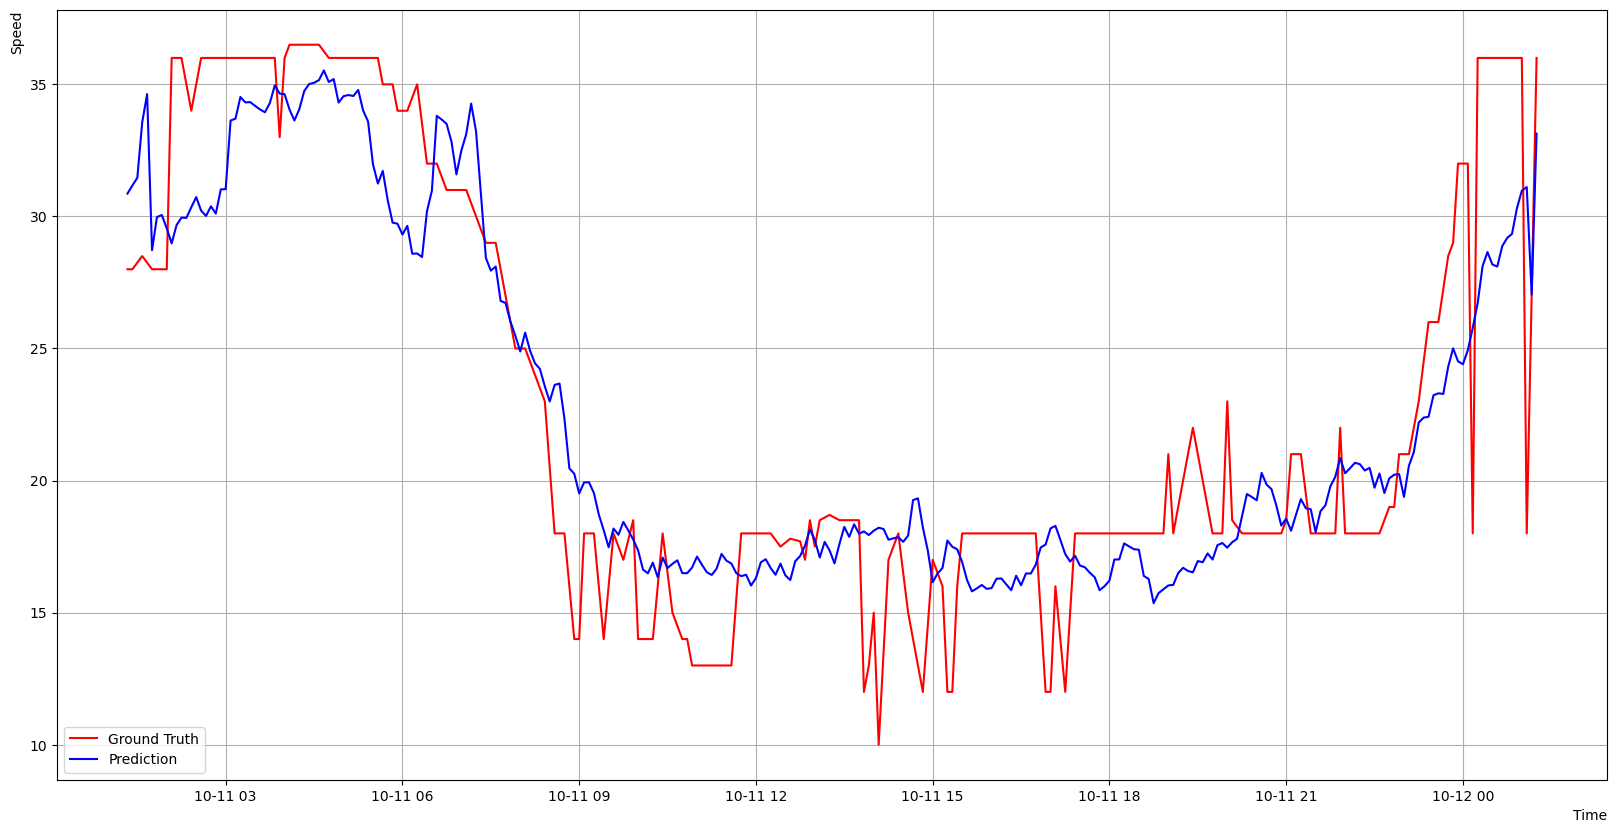

2.58308302031623


In [22]:
d1_start = prev_len + next_step - 1
start_offset = 288*10

time_len = 288 * 1
road_idx = 24

d = pd.read_csv(cur_data[2])
x = [cur_data[5] + i*datetime.timedelta(minutes=5) for i in range(d1_start+start_offset, d1_start+start_offset+time_len)]
d1 = d.iloc[d1_start+start_offset:d1_start+start_offset+time_len, road_idx]
d1 = pd.Series(d1).set_axis(x)
d2 = result[start_offset:time_len+start_offset, road_idx]
d2 = pd.Series(d2).set_axis(x)
show_plot(d1, d2)
print(np.abs((d1-d2)).mean())

In [23]:
mx = 0
mae = []
mse = []
mape = []
for i in range(len(d.iloc[0])):
    d1 = d.iloc[d1_start:, i].reset_index(drop=True)
    d2 = result[:,i]
    err = np.abs(d1-d2)
    print(i, err.mean(), np.sqrt((err**2).mean()))
    mx = max(mx, err.max())
    mae += err.to_list()
    mse += (err**2).to_list()
    mape += (err / d1).tolist()

mae_v = np.array(mae).mean()
rmse_v = np.sqrt(np.array(mse).mean())
mape_v = np.array(mape)
np.place(mape_v, np.isinf(mape_v), [0])
mape_v = mape_v.sum() / np.count_nonzero(mape_v)
print(f'MAX diff: {mx}, MAE: {mae_v}, RMSE: {rmse_v}, MAPE: {mape_v*100}%')

0 4.17794393984346 5.674280017883242
1 2.9198465637176025 4.382674935600141
2 5.258848094764002 6.904545235690178
3 5.0550663860428315 6.498730193281365
4 4.004145738372469 5.170180695495152
5 4.102052185222719 5.801442350228683
6 3.8178052768401702 4.763748763713449
7 4.138452270703232 5.299408814009969
8 4.365845966427818 5.443044245395815
9 4.9755619266697 6.49204395394312
10 3.5169498086594837 4.9101482299080565
11 4.284208484393508 5.918335537274396
12 5.191210113120928 6.502002474178985
13 3.871677818678306 4.938177077719114
14 1.9876456983873356 2.89828590289637
15 2.1477525168995037 3.357030617621369
16 2.6896181929162606 3.3356946355265893
17 2.4745625776135007 3.3815834416003856
18 0.7683999160225183 1.4945453984045691
19 1.7333908100959763 3.2175793694804984
20 3.2548985972249986 4.696761598797348
21 5.426566325777758 6.7441834885291065
22 5.461767810834251 6.814076957321696
23 5.179089535698532 6.291401429046042
24 2.999217633522914 4.059252044399106
25 3.865456415572639 5.

402 3.2400806171440135 4.549570783711282
403 4.183943035423713 5.284901393448881
404 4.992951535227294 6.927335568393278
405 7.250254675054816 9.746217632847936
406 12.14582929230798 17.35514316156568
407 3.2317090861651363 4.278559408312565
408 7.418305096025132 9.206970110695803
409 4.391810402135972 5.390376360773143
410 3.8462345936318503 5.952623437842245
411 4.003406081658411 5.206621326220606
412 3.823531042003729 5.093987627379198
413 4.2386393227468995 5.489221912195958
414 3.7065456462037774 4.756264997349461
415 0.5957948327728017 0.6854567398444525
416 0.5678201060127017 0.9477837673935157
417 0.5932738119684478 0.7949365859455843
418 0.47979210745646916 0.5953933646486477
419 0.37804477665994957 0.552868125861211
420 0.775737210527643 2.639728685915422
421 0.4024563990187778 0.7432038097519321
422 0.5250924639887624 1.5363537904959172
423 0.7175224282967138 1.134380463530775
424 0.5264346985516167 1.5950666416272574
425 1.3118706839867558 3.9027155163834135
426 0.662244644

# Visualize (ITS Only!!)

In [35]:
nodes = pd.read_csv('./data/processed_data/node_link/daegu_selected_nodes.csv')
links = pd.read_csv('./data/processed_data/node_link/daegu_selected_links.csv', dtype={'LINK_ID':'str'})

In [112]:
def show_map(time_idx):
    now = cur_data[5] + (prev_len+time_idx-1)*datetime.timedelta(minutes=5)
    fut = cur_data[5] + (prev_len+time_idx+next_step-1)*datetime.timedelta(minutes=5)
    m = folium.Map(location=tuple(nodes.head(1)[['latitude','longitude']].iloc[0]), zoom_start=14) 

    for i, row in links.iterrows():
        src = tuple(nodes[nodes['NODE_ID']==row['F_NODE']][['latitude','longitude']].iloc[0])
        dest = tuple(nodes[nodes['NODE_ID']==row['T_NODE']][['latitude','longitude']].iloc[0])

        nv = (-(dest[1]-src[1]), dest[0]-src[0])
        nm = math.sqrt((nv[0]**2 + nv[1]**2)) * 20000
        nnv = (nv[0]/nm, nv[1]/nm)

        ms = (src[0]+nnv[0], src[1]+nnv[1])
        md = (dest[0]+nnv[0], dest[1]+nnv[1])

        folium.PolyLine(
            locations=[ms, md],
            color='black',
            opacity=1,
            weight=5,
        ).add_to(m)

        folium.PolyLine(
            locations=[ms, md],
            color=f'{"red" if result[time_idx][i] < row["MAX_SPD"]*0.3 else ("yellow" if result[time_idx][i] < row["MAX_SPD"]*0.5 else "green")}',
            opacity=1,
            weight=4,
            tooltip=f'<div style="font-size:12px;font-weight:bold;">링크ID: {row["LINK_ID"]}<br>길이: {int(row["LENGTH"])}m<br>최대 속도: {row["MAX_SPD"]}km/s<br>현재 속도: {d.iloc[time_idx+prev_len-1, i]:.1f}km/s<br>예측 속도: {result[time_idx][i]:.1f}km/s</div>'
        ).add_to(m)

    for _, row in nodes.iterrows():
        location = (row['latitude'], row['longitude'])
        folium.Circle(
            location=location,
            radius=10,
            color='white',
            weight=1,
            fill_opacity=0.5,
            opacity=1,
            fill_color='black',
            fill=True
        ).add_to(m)    

    m.get_root().html.add_child(folium.Element(f'<div style="font-size:20px;font-weight:bold;background:white;position:absolute;bottom:0;z-index:10000;border:1px solid black;">현재: {now}<br>예측: {fut}</div>'))

    return m

In [116]:
# time_idx 로 시간 조절
time_idx = 120
show_map(time_idx)